# Time Series Forecasting
Just get to grips with time series.

In [7]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [8]:
import numpy as np
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

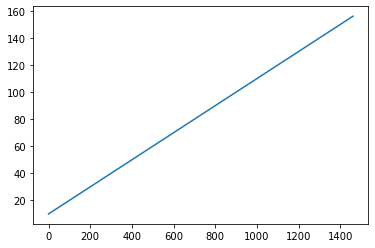

<IPython.core.display.Javascript object>

In [9]:
time = np.arange(4*365 + 1)
baseline = 10
series = baseline + 0.1 * time

fig, ax = plt.subplots()
ax.plot(time, series)


In [15]:
def seasonal_pattern(season_time: np.array):
    """
    This is arbitrary -- there could be multiple seasonal patterns.
    """
    return np.where(
        season_time < 0.4, np.cos(season_time * 2 * np.pi), np.exp(-3 * season_time)
    )


def seasonality(time: np.array, period: float, amplitude: float = 1, phase: float = 0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time: np.array, noise_level: float, seed: int = 31415926):
    rng = np.random.default_rng(seed=seed)
    return rng.random(time.shape[0]) * noise_level

<IPython.core.display.Javascript object>

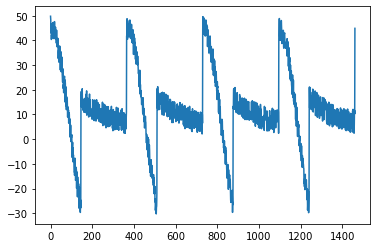

<IPython.core.display.Javascript object>

In [16]:
fig, ax = plt.subplots()
ax.plot(time, seasonality(time, period=365, amplitude=40) + white_noise(time, 10))

## Naive Forecasting
Let's do some traditional prediction methods. 
The naive forecast is that tomorrow will be the same as today.


In [22]:
series = seasonality(time, period=365, amplitude=40) + white_noise(time, 10)
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

<IPython.core.display.Javascript object>

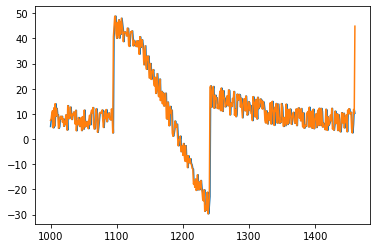

<IPython.core.display.Javascript object>

In [37]:
naive_forecast = series[split_time - 1 : -1]
plt.plot(time_valid, naive_forecast, label="Naive")
plt.plot(time_valid, x_valid, label="True")

We commonly use the MSE, mean squared error, as a metric.
We can also use the RMS error which is of the same scale as the values, but MAE or MSE also valid.

In [25]:
import tensorflow as tf

<IPython.core.display.Javascript object>

In [27]:
tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()

3.55240788188095

<IPython.core.display.Javascript object>

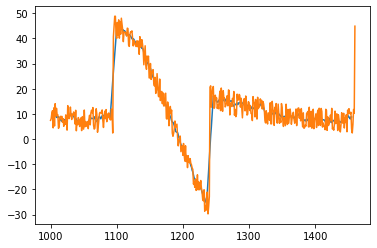

<IPython.core.display.Javascript object>

In [38]:
def moving_average_forecast(series, window_size):
    """
  Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast
     This implementation is *much* faster than the previous one
     """
    mov = np.cumsum(series)
    mov[window_size:] = mov[window_size:] - mov[:-window_size]
    return mov[window_size - 1:-1] / window_size
plt.plot(time_valid[5:-5], moving_average_forecast(x_valid, 10))
plt.plot(time_valid, x_valid)


In [39]:
tf.keras.metrics.mean_absolute_error(
    x_valid[5:-5], moving_average_forecast(x_valid, 10)
).numpy()

2.728117470633646

<IPython.core.display.Javascript object>

Moving averages don't copy well with seasonality, so instead we should use a difference series.

In [46]:
offset = 365
diff_series = series[offset:] - series[:-offset]
diff_mov_avg = moving_average_forecast(diff_series, 50)[split_time - offset - 50 :]

<IPython.core.display.Javascript object>

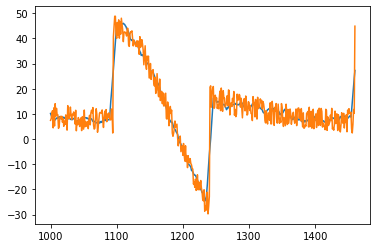

<IPython.core.display.Javascript object>

In [47]:
averaged_past = moving_average_forecast(
    series[split_time - offset - 5 : -(offset - 5 - 1)], 11
)

plt.plot(time_valid, diff_mov_avg + averaged_past)
plt.plot(time_valid, x_valid)

In [50]:
tf.keras.metrics.mean_absolute_error(x_valid, diff_mov_avg + averaged_past).numpy()

3.1579736906257234

<IPython.core.display.Javascript object>